ESPN base 建模資料前處理

In [67]:
import sys
sys.path.append('G:\我的雲端硬碟\python')
import numpy as np
from polib.CsvEngn import *
from MLB_functions import *
from tqdm import tqdm

import requests as rs
from bs4 import BeautifulSoup

from scipy import stats #計算標準差

# 讀取ESPN FA 與表現合併

## 讀取2006~2019年 簽約資料

In [2]:
ESPN_FA_path = r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\6.ESPN_free_agent\ESPN_FreeAgent_2006to2019_20210417_12.00.34.csv"
ESPN_FA_df = read_data_dir_fPathExt(ESPN_FA_path)

  >> 讀取:: G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\6.ESPN_free_agent\ESPN_FreeAgent_2006to2019_20210417_12.00.34.csv


In [3]:
ESPN_FA_df.rename(columns={"PLAYER_id":"playerID", "YRS":"contract_Yrs"}, inplace=True)

In [4]:
# ESPN_FA_df["contract_Yrs"].value_counts()
# ESPN_FA_df[ESPN_FA_df["contract_Yrs"].isin([13])]

In [5]:
# ESPN_FA_df[ESPN_FA_df["PLAYER"].str.contains("Moo")]
# ESPN_FA_df[ESPN_FA_df["playerID"].isin(["28525"])]

## 讀取 簽約資料中球員歷年表現

In [4]:
ESPN_stats_path = r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\6.ESPN_free_agent\ESPN_player_stats_all_20210417_14.12.52.csv"
ESPN_stats_df = read_data_dir_fPathExt(ESPN_stats_path)

ESPN_bio_path = r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\6.ESPN_free_agent\ESPN_player_bio_all_20210417_15.23.45.csv"
ESPN_bio_df = read_data_dir_fPathExt(ESPN_bio_path)

  >> 讀取:: G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\6.ESPN_free_agent\ESPN_player_stats_all_20210417_14.12.52.csv
  >> 讀取:: G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\6.ESPN_free_agent\ESPN_player_bio_all_20210417_15.23.45.csv


In [5]:
# 格式轉換
ESPN_stats_df["playerID"] = ESPN_stats_df["playerID"].astype("str")
ESPN_bio_df["playerID"] = ESPN_bio_df["playerID"].astype("str")
ESPN_FA_df["playerID"] = ESPN_FA_df["playerID"].astype("str")

ESPN_stats_df["season"] = ESPN_stats_df["season"].astype("str")
ESPN_FA_df["YEAR"] = ESPN_FA_df["YEAR"].astype("str")

### ESPN_FA_df 球隊 正規化

In [6]:
print(f"ORG TEAM nunique: {ESPN_FA_df['ORG TEAM'].nunique()}\n\
NEW TEAM nunique: {ESPN_FA_df['NEW TEAM'].nunique()}\n\
Team nunique: {ESPN_stats_df['Team'].nunique()}")

ORG TEAM nunique: 34
NEW TEAM nunique: 32
Team nunique: 37


In [7]:
# ESPM MLB 球隊代號
url = "https://www.espn.com/mlb/teams"
response = rs.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
_as = soup.find_all('a')

team_dict = {}
for a in _as:
    try:
        if "/mlb/team/_/name/" in a['href']:
            teamFullName = a['href'].split("/")[-1].replace("-"," ").title()
            teamID = a['href'].split("/")[-2].upper()
            team_dict[teamFullName] = teamID
            
    except:
            pass

print(len(team_dict))
# team_dict

30


In [8]:
def team_ID_finder(team_name):
    for s_name in team_name.split(" "):
        for full_name, teamID in team_dict.items():
            if s_name in full_name:
                return teamID
    return np.nan

In [9]:
ESPN_FA_df.loc[:, "ORG_TEAM_ID"] = ESPN_FA_df.loc[:, "ORG TEAM"].apply(team_ID_finder)
ESPN_FA_df.loc[:, "NEW_TEAM_ID"] = ESPN_FA_df.loc[:, "NEW TEAM"].apply(team_ID_finder)

In [10]:
# 檢查那些縮寫有問題
team_dict_inverse = {v: k for k, v in team_dict.items()}

for t in ESPN_stats_df['Team'].unique():
    try:
        team_dict_inverse[t]
    except:
        print(t)

CWS
MON
FLA
WAS
CAL
ANA
CHI


In [11]:
# team_dict_inverse

In [12]:
# 球隊名稱清理

def team_ID_cleaner(teamID):
    if teamID == "FLA":
        return "MIA"
    
    if (teamID == "CWS"):
        return "CHW"
    
    if (teamID == "ANA") | (teamID == "CAL"):
        return "LAA"
    
    if (teamID == "MON") | (teamID == "WAS"):
        return "WSH"
    
    if teamID == "CHI":
        return np.nan
    
    return teamID


#### 篩選掉 Team有錯誤的球員 1筆 (id: 23283, Mike Jacobs)

In [13]:
ESPN_stats_df['Team_clean'] = ESPN_stats_df['Team'].apply(team_ID_cleaner)
ESPN_stats_df = ESPN_stats_df[pd.notna(ESPN_stats_df["Team_clean"])].reset_index(drop=True)
print(len(ESPN_stats_df))

15999


In [14]:
print(f"ORG TEAM(ID) nunique: {ESPN_FA_df['ORG_TEAM_ID'].nunique()}\n\
NEW TEAM(ID) nunique: {ESPN_FA_df['NEW_TEAM_ID'].nunique()}\n\
Team(clean) nunique: {ESPN_stats_df['Team_clean'].nunique()}")

ORG TEAM(ID) nunique: 30
NEW TEAM(ID) nunique: 30
Team(clean) nunique: 30


In [15]:
# 以 Team_clean 取代 Team
ESPN_stats_df['Team'] = ESPN_stats_df['Team_clean'].copy(deep=True)

In [16]:
# 檢查FA資料中球隊缺值情況
print(len(ESPN_FA_df))
print(f"ORG_TEAM_ID null: {ESPN_FA_df.loc[:, 'ORG_TEAM_ID'].isna().sum()}\nNEW_TEAM_ID null: {ESPN_FA_df.loc[:, 'NEW_TEAM_ID'].isna().sum()}")

mask_org = pd.isna(ESPN_FA_df.loc[:, "ORG_TEAM_ID"])
mask_new = pd.isna(ESPN_FA_df.loc[:, "NEW_TEAM_ID"])
print(ESPN_FA_df.loc[mask_org, "ORG TEAM"].unique(), ESPN_FA_df.loc[mask_new, "NEW TEAM"].unique())

2910
ORG_TEAM_ID null: 46
NEW_TEAM_ID null: 599
['--' 'Japan' 'Cuba'] ['--' 'Japan']


### 最後出賽年 (TODO 待討論)

In [17]:
player_max_season_df = ESPN_stats_df[["playerID","season"]].groupby(["playerID"], as_index=False).max()
player_max_season_df["season"].value_counts()

2021    178
2019    124
2018    103
2020     99
2017     99
2011     88
2013     88
2010     88
2009     82
2014     81
2015     77
2016     76
2012     74
2008     72
2007     71
2006     31
2005      4
Name: season, dtype: int64

### 將bio 欄位(POS、DOB、Birthplace、Type)合併入stats 

In [18]:
# 挑選需要的欄位
cols_pic = [
#     '_idx',
    'season',
    'Team',
    'GP',
    'GS',
#     'W',
#     'L',
#     'W%',
    'WAR',
    'ERA',
#     'WHIP',
    'IP',
    'K',
    'BB',
#     'K/BB',
#     'H',
#     'R',
#     'ER',
#     'SV',
#     'HLD',
#     'BLSV',
    'playerID',
    'Yrs',
    'AB',
#     '2B',
#     '3B',
#     'HR',
#     'RBI',
#     'HBP',
#     'SO',
#     'SB',
#     'CS',
#     'AVG',
#     'OBP',
#     'SLG',
    'OPS'
]

ESPN_stats_bio_df = ESPN_stats_df[cols_pic].merge(ESPN_bio_df[["playerID", "POS", "DOB", "Birthplace", "TYPE"]], how="left", on=["playerID"])
print(len(ESPN_stats_df), len(ESPN_stats_bio_df))

15999 15999


In [19]:
ESPN_bio_df["TYPE"].value_counts()

pitch    728
bat      725
Name: TYPE, dtype: int64

#### 檢查TYPE是否正確(主職(投手沒OPS、打者沒ERA)) >> OK 

In [20]:
# mask_check = (ESPN_stats_bio_df["TYPE"].isin(["pitch"]))&(pd.notna(ESPN_stats_bio_df["OPS"]))
# ESPN_stats_bio_df[mask_check]

# mask_check = (ESPN_stats_bio_df["TYPE"].isin(["bat"]))&(pd.notna(ESPN_stats_bio_df["ERA"]))
# ESPN_stats_bio_df[mask_check]

### 守備位置正規化

In [21]:
def POS_cleaner(value):
    if "Starting Pitcher" in value:
        return "SP"
    
    elif ("Relief Pitcher" in value) | ("Pitcher" in value):
        return "RP"
    
    elif ("Fielder" in value) | ("Outfielder" in value):
        return "OF"

    elif "Shortstop" in value:
        return "SS"

    elif "First Baseman" in value:
        return "1B"

    elif "Second Baseman" in value:
        return "2B"

    elif "Third Baseman" in value:
        return "3B"

    elif "Catcher" in value:
        return "C"
    
    elif "Designated Hitter" in value:
        return "DH"
    
    else:
        return np.nan

In [22]:
ESPN_stats_bio_df["POS_c"] = ESPN_stats_bio_df["POS"].apply(POS_cleaner)

In [23]:
ESPN_stats_bio_df[pd.isna(ESPN_stats_bio_df["POS_c"])]["POS"].unique()

array(['DOB'], dtype=object)

In [24]:
ESPN_stats_bio_df[pd.isna(ESPN_stats_bio_df["POS_c"])]

,season,Team,GP,GS,WAR,ERA,IP,K,BB,playerID,Yrs,AB,OPS,POS,DOB,Birthplace,TYPE,POS_c
14857,2018,MIA,31,NaN,0.0,NaN,NaN,NaN,0,33619,1,4.0,0.0,DOB,12/30/1988,"Neenah, WI",bat,NaN


#### 篩選掉沒有正確POS資訊的選手 1名 (id: 33619)

In [25]:
ESPN_stats_bio_df = ESPN_stats_bio_df[pd.notna(ESPN_stats_bio_df["POS_c"])].reset_index(drop=True)
print(len(ESPN_stats_bio_df))

15998


In [26]:
print(ESPN_stats_bio_df["POS_c"].isna().sum())
ESPN_stats_bio_df["POS_c"].value_counts()

0


RP    4899
SP    2843
OF    2747
C     1387
1B    1050
2B    1016
3B     925
SS     670
DH     461
Name: POS_c, dtype: int64

### 清理DOB，計算年齡

In [27]:
# ESPN_stats_bio_df["DOB"].unique()

In [28]:
ESPN_stats_bio_df["DOB"] = ESPN_stats_bio_df["DOB"].apply(lambda s: s.split(" ")[0])
ESPN_stats_bio_df["DOB_fmt"] = pd.to_datetime(ESPN_stats_bio_df["DOB"], format='%m/%d/%Y', errors='coerce')
ESPN_stats_bio_df["Age"] = ESPN_stats_bio_df["season"].astype("int") - ESPN_stats_bio_df["DOB_fmt"].dt.year +1

## 表現資料串簽約資料 (球員ID、年分、原球隊)

In [29]:
ESPN_FA_df.rename(columns={"ORG_TEAM_ID":"Team"}, inplace=True)

# 合約年串檔
FA_cols = ["playerID", "YEAR", "Team", "NEW_TEAM_ID", "contract_Yrs", "DOLLARS", "STATUS"]
ESPN_stats_bio_FA_df = ESPN_stats_bio_df.merge(ESPN_FA_df[FA_cols], how="left", 
    left_on=["playerID", "season", "Team"], right_on=["playerID","YEAR","Team"])

# 合約年-1 串檔
ESPN_FA_df["YEAR_before"] = ESPN_FA_df["YEAR"].apply(lambda y: str(int(y)-1))
ESPN_stats_bio_FA_df = ESPN_stats_bio_FA_df.merge(ESPN_FA_df[["playerID","YEAR_before","Team"]], how="left", 
    left_on=["playerID", "season", "Team"], right_on=["playerID","YEAR_before","Team"])

# 合約年+1 串檔
ESPN_FA_df["YEAR_after"] = ESPN_FA_df["YEAR"].apply(lambda y: str(int(y)+1))
ESPN_stats_bio_FA_df = ESPN_stats_bio_FA_df.merge(ESPN_FA_df[["playerID","YEAR_after","Team"]], how="left", 
    left_on=["playerID", "season", "Team"], right_on=["playerID","YEAR_after","Team"])

In [30]:
# ESPN_stats_bio_FA_df.head()

In [31]:
print(len(ESPN_stats_bio_df),len(ESPN_stats_bio_FA_df))

15998 15998


In [32]:
ESPN_stats_bio_FA_df["Team"].notna().sum() / len(ESPN_stats_bio_FA_df)

1.0

# 合併後變數處裡與分割

## 處理薪水， 將合約薪水攤到每一年去(TODO )

光有FA合約年的簽約薪資無法拚湊出每一年的薪資(新合約發生在成為FA前)，比對BR的資料出入太大(ex:Matt Albers ESPN ID: 28525)

In [33]:
mask_dont = (ESPN_stats_bio_FA_df["DOLLARS"].str.contains('Minor|-', regex=True)) | (pd.isna(ESPN_stats_bio_FA_df["DOLLARS"]))
ESPN_stats_bio_FA_df.loc[mask_dont, "DOLLARS"] = np.nan
ESPN_stats_bio_FA_df.loc[~mask_dont, "DOLLARS"] = ESPN_stats_bio_FA_df.loc[~mask_dont, "DOLLARS"].replace('[\$,]', '', regex=True).astype(float)
ESPN_stats_bio_FA_df["DOLLARS_M"] = ESPN_stats_bio_FA_df["DOLLARS"].apply(lambda n: n/(10**6) if isinstance(n,float) else np.nan)
ESPN_stats_bio_FA_df["DOLLARS_M"].describe()

count    1387.000000
mean       15.100686
std        32.473158
min         0.380000
25%         2.000000
50%         4.500000
75%        13.000000
max       330.000000
Name: DOLLARS_M, dtype: float64

In [34]:
# ESPN_stats_bio_FA_df[ESPN_stats_bio_FA_df["playerID"].isin(["28525"])]

In [35]:
#TODO

## 分割資料: 1.每人每年在各球隊(已有:ESPN_stats_bio_FA_df)、2.每人每年整體(若單年有跨球隊表現會從 ESPN球員 Split分頁中找到整體值)

In [36]:
# ESPN_stats_bio_FA_df[ESPN_stats_bio_FA_df["playerID"].isin(["28525"])]

### 找出有單年度跨球隊表現的球員季度 (2006之後)

In [37]:
palyer_season_team_count_df = ESPN_stats_bio_FA_df.groupby(["playerID","season", "TYPE"], as_index=False)["Team"].count()
palyer_season_team_count_GOAL_df = palyer_season_team_count_df[(palyer_season_team_count_df["Team"]>1)&(palyer_season_team_count_df["season"].astype(int)>=2006)]

### 回ESPN 球員 Split 分頁 找到當年度整體表現 **(已執行過不再執行)**

#### ERA、OPS 的公式算法? 

In [38]:
# import time

# playerID_lst = []
# year_lst = []
# type_lst = []
# goal_col_name_lst = []
# goal_col_value_lst = []
# for _id, year, _type in tqdm(palyer_season_team_count_GOAL_df[["playerID", "season", "TYPE"]].values):
    
#     if _type == "pitch":
#         type_for_url = "pitching"
#         goal_col_name = "ERA"
    
#     if _type == "bat":
#         type_for_url = "batting"
#         goal_col_name = "OPS"

#     url = f"https://www.espn.com/mlb/player/splits/_/id/{_id}/year/{year}/category/{type_for_url}"
#     try:
#         s = pd.read_html(url)
#         df_temp = s[1].copy(deep=True)
#         df_temp.columns = s[1].loc[0,:].values
#         df_temp.drop(index=[0], inplace=True)
#         goal_col_value = float(df_temp.loc[1,goal_col_name])

#         playerID_lst.append(_id)
#         year_lst.append(year)
#         type_lst.append(_type)
#         goal_col_name_lst.append(goal_col_name)
#         goal_col_value_lst.append(goal_col_value)
        
#     except:
#         print(url)
    
#     time.sleep(1)

In [39]:
# GOAL_df = pd.DataFrame(
#     {'playerID': playerID_lst,
#      'season': year_lst,
#      'TYPE': type_lst,
#      'goal_col_name': goal_col_name_lst,
#      'goal_col_value': goal_col_value_lst
#     })

In [40]:
# # 輸出備份
# formtoCsv(GOAL_df, "GOAL_df")

In [41]:
# 讀取備份
GOAL_df = read_data_dir_fPathExt(r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\6.ESPN_free_agent\GOAL_df_20210417_21.08.00.csv")
GOAL_df.rename(columns={"type":"TYPE"},inplace=True)
GOAL_df["playerID"] = GOAL_df["playerID"].astype(str)
GOAL_df["season"] = GOAL_df["season"].astype(str)

  >> 讀取:: G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\6.ESPN_free_agent\GOAL_df_20210417_21.08.00.csv


### mutilTeam_count>1 串GOAL_df，後在與 mutilTeam_count=1 合併

In [42]:
palyer_season_team_count_GOAL_df.rename(columns={"Team":"mutilTeam_count"})
ESPN_stats_bio_FA_df = ESPN_stats_bio_FA_df.merge(palyer_season_team_count_GOAL_df.rename(columns={"Team":"mutilTeam_count"})
                                                 , how="left",on=["playerID", "season", "TYPE"])

ESPN_stats_bio_FA_df.loc[:,"mutilTeam_count"] = ESPN_stats_bio_FA_df.loc[:,"mutilTeam_count"].fillna(1)
print(len(ESPN_stats_bio_FA_df))

15998


In [43]:
temp_split_mutil_df = ESPN_stats_bio_FA_df[ESPN_stats_bio_FA_df["mutilTeam_count"]>1].reset_index(drop=True)
temp_split_one_df = ESPN_stats_bio_FA_df[ESPN_stats_bio_FA_df["mutilTeam_count"]==1].reset_index(drop=True)

In [44]:
pd.__version__ # 0.25.3
# https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns/53096340

'1.1.3'

In [45]:
# 加總 GP、WAR； 平均
cols = [
 'season',
# 'Team',
 'GP',
 'GS',
 'WAR',
#  'ERA',
 'IP',
 'K',
 'BB',
 'playerID',
#  'Yrs',
 'AB',
#  'OPS',
#  'POS',
#  'DOB',
#  'Birthplace',
 'TYPE',
#  'POS_c',
#  'DOB_fmt',
#  'Age',
#  'YEAR',
#  'ORG_TEAM_ID',
#  'NEW_TEAM_ID',
#  'contract_Yrs',
#  'DOLLARS',
#  'STATUS',
#  'DOLLARS_M',
#  'mutilTeam_count'
]




temp_split_mutil_gp_df = temp_split_mutil_df[cols].groupby(['playerID','season','TYPE']).agg(
    {
            "GP": "sum",
            "WAR":"sum",
            "GS":"sum",
            "IP":"sum",
            "K":"sum",
            "BB":"sum",
            "AB":"sum",
            }).reset_index()

temp_split_mutil_gp_df.columns = ['playerID','season','TYPE', 'GP' , 'WAR', 'GS', 'IP', 'K', 'BB', 'AB']

# temp_split_mutil_gp_df

#### temp_split_mutil_gp_df 串 GOAL_df

In [46]:
# bat
temp_split_mutil_gp_bat_df = temp_split_mutil_gp_df[temp_split_mutil_gp_df["TYPE"].isin(["bat"])].merge(GOAL_df[["playerID","season","TYPE","goal_col_value"]]
                                                                          , how="left", on=["playerID","season","TYPE"])
temp_split_mutil_gp_bat_df.rename(columns={"goal_col_value":"OPS"},inplace=True)

# pitch
temp_split_mutil_gp_pitch_df = temp_split_mutil_gp_df[temp_split_mutil_gp_df["TYPE"].isin(["pitch"])].merge(GOAL_df[["playerID","season","TYPE","goal_col_value"]]
                                                                          , how="left", on=["playerID","season","TYPE"])
temp_split_mutil_gp_pitch_df.rename(columns={"goal_col_value":"ERA"},inplace=True)

In [47]:
temp_split_mutil_gp_m_df = pd.concat([temp_split_mutil_gp_bat_df, temp_split_mutil_gp_pitch_df], axis=0,sort=False).reset_index(drop=True)
print(len(temp_split_mutil_gp_m_df))

1088


In [48]:
#串回個人欄位
temp_split_mutil_gp_m_df = temp_split_mutil_gp_m_df.merge(ESPN_stats_bio_FA_df[["playerID","season","Yrs","Birthplace","POS_c","Age"]].drop_duplicates(
                                                            subset=["playerID","season"],keep="first")
                                                          , how="left",on=["playerID","season"])
print(len(temp_split_mutil_gp_m_df))

1088


In [49]:
#串回合約資料
temp_split_mutil_gp_m_df = temp_split_mutil_gp_m_df.merge(ESPN_stats_bio_FA_df[["playerID","season",'YEAR','Team', 'NEW_TEAM_ID', 'contract_Yrs'
                                                                               ,'DOLLARS', 'STATUS','DOLLARS_M']].sort_values(by=["YEAR"],ascending=[1]
                                                            ).drop_duplicates(
                                                            subset=["playerID","season"],keep="first")
                                                          , how="left",on=["playerID","season"])
print(len(temp_split_mutil_gp_m_df))

1088


#### 與 mutilTeam_count=1 合併

In [50]:
# temp_split_mutil_gp_m_df.drop_duplicates(subset=["playerID","season"],keep="first")

In [51]:
#部分2006年以前的會撐開，但等等就拿掉了
ESPN_stats_bio_FA_no_team_gp_df = pd.concat([temp_split_mutil_gp_m_df, temp_split_one_df[temp_split_mutil_gp_m_df.columns.to_list()+["mutilTeam_count","YEAR_before","YEAR_after"]]], axis=0,sort=False).sort_values(
    by=["playerID","season"],ascending=[1,1]).reset_index(drop=True)
print(len(ESPN_stats_bio_FA_no_team_gp_df))

14864


## 延伸變數製作

### 合約年 dummy 製作

In [52]:
# 合約年
ESPN_stats_bio_FA_df["is_FA_contract_year"] = ESPN_stats_bio_FA_df["YEAR"].apply(lambda y: pd.notna(y))
ESPN_stats_bio_FA_no_team_gp_df["is_FA_contract_year"] = ESPN_stats_bio_FA_no_team_gp_df["YEAR"].apply(lambda y: pd.notna(y))

# 合約年-1 (before)
ESPN_stats_bio_FA_df["is_FA_contract_year_before"] = ESPN_stats_bio_FA_df["YEAR_before"].apply(lambda y: pd.notna(y))
ESPN_stats_bio_FA_no_team_gp_df["is_FA_contract_year_before"] = ESPN_stats_bio_FA_no_team_gp_df["YEAR_before"].apply(lambda y: pd.notna(y))

# 合約年+1 (after)
ESPN_stats_bio_FA_df["is_FA_contract_year_after"] = ESPN_stats_bio_FA_df["YEAR_after"].apply(lambda y: pd.notna(y))
ESPN_stats_bio_FA_no_team_gp_df["is_FA_contract_year_after"] = ESPN_stats_bio_FA_no_team_gp_df["YEAR_after"].apply(lambda y: pd.notna(y))

### 年齡平方

In [53]:
ESPN_stats_bio_FA_df["Age_sq"] = ESPN_stats_bio_FA_df["Age"] * ESPN_stats_bio_FA_df["Age"]
ESPN_stats_bio_FA_no_team_gp_df["Age_sq"] = ESPN_stats_bio_FA_no_team_gp_df["Age"] * ESPN_stats_bio_FA_no_team_gp_df["Age"]

### ERA 數值清理

In [54]:
def str_to_float_cleaner(str_value):
    try:
        if "inf" in str_value:
            return np.nan
        
        return float(str_value)
        
    except:
        return np.nan

In [55]:
ESPN_stats_bio_FA_df["ERA"] = ESPN_stats_bio_FA_df["ERA"].apply(str_to_float_cleaner)
ESPN_stats_bio_FA_no_team_gp_df["ERA"] = ESPN_stats_bio_FA_no_team_gp_df["ERA"].apply(str_to_float_cleaner)

### 數值ID (playerID_num、season_num) 

In [56]:
ESPN_stats_bio_FA_df["playerID_num"] = ESPN_stats_bio_FA_df["playerID"].astype(int)
ESPN_stats_bio_FA_no_team_gp_df["playerID_num"] = ESPN_stats_bio_FA_no_team_gp_df["playerID"].astype(int)

ESPN_stats_bio_FA_df["season_num"] = ESPN_stats_bio_FA_df["season"].astype(int)
ESPN_stats_bio_FA_no_team_gp_df["season_num"] = ESPN_stats_bio_FA_no_team_gp_df["season"].astype(int)

### K/BB (三振數/保送數)

In [57]:
ESPN_stats_bio_FA_df.loc[:, "K/BB"] = ESPN_stats_bio_FA_df.loc[:, "K"] / ESPN_stats_bio_FA_df.loc[:, "BB"]
ESPN_stats_bio_FA_df.loc[ESPN_stats_bio_FA_df["K/BB"]>100, "K/BB"] = np.nan

ESPN_stats_bio_FA_no_team_gp_df.loc[:, "K/BB"] = ESPN_stats_bio_FA_no_team_gp_df.loc[:, "K"] / ESPN_stats_bio_FA_no_team_gp_df.loc[:, "BB"]
ESPN_stats_bio_FA_no_team_gp_df.loc[ESPN_stats_bio_FA_no_team_gp_df["K/BB"]>100, "K/BB"] = np.nan

In [58]:
# ESPN_stats_bio_FA_df.loc[:, "K/BB"].describe()
# ESPN_stats_bio_FA_no_team_gp_df.loc[:, "K/BB"].describe()

### DV (deviation) 製作: 目標Y(WAR、OPS、ERA)，計算當年值-前三年移動平均，no Team only

In [59]:
# ESPN_stats_bio_FA_no_team_gp_df.head()

In [60]:
for y in ["WAR","ERA","K/BB","IP","AB","OPS"]:
    # 1.製作 y_lag_1
    y_lag_1 = f"{y}_lag_1"
    ESPN_stats_bio_FA_no_team_gp_df.loc[:, y_lag_1] = ESPN_stats_bio_FA_no_team_gp_df.sort_values(
                                by=["playerID", "season"], ascending=[1,1]).groupby(["playerID"])[y].shift(1)
    
    # 2. 製作以y_lag_1為底的3年移動平均(可容忍3缺1筆)
    y_lag_1_MA3 = f"{y_lag_1}_MA3"
    ESPN_stats_bio_FA_no_team_gp_df.loc[:, y_lag_1_MA3] = ESPN_stats_bio_FA_no_team_gp_df.sort_values(
                                by=["playerID", "season"], ascending=[1,1]).groupby(["playerID"])[y_lag_1].rolling(
                                window=3,min_periods=2).mean().reset_index().set_index("level_1")[y_lag_1].apply(
                                lambda m: round(m,2) if pd.notna(m) else np.nan )
    
    # 3. 製作DV (當年y - y_lab1_1_MA3)
    y_DV = f"{y}_DV"
    ESPN_stats_bio_FA_no_team_gp_df.loc[:, y_DV] = ESPN_stats_bio_FA_no_team_gp_df.loc[:, y] \
                                                    - ESPN_stats_bio_FA_no_team_gp_df.loc[:, y_lag_1_MA3]

In [61]:
ESPN_stats_bio_FA_no_team_gp_df[["playerID", "season", "K/BB", "K/BB_lag_1", "K/BB_lag_1_MA3", "K/BB_DV"]][-6:]

,playerID,season,K/BB,K/BB_lag_1,K/BB_lag_1_MA3,K/BB_DV
14858,6531,2006,1.153846,NaN,NaN,NaN
14859,6531,2007,1.558824,1.153846,NaN,NaN
14860,6531,2008,1.722222,1.558824,1.36,0.362222
14861,6531,2009,1.500000,1.722222,1.48,0.020000
14862,6531,2010,1.500000,1.500000,1.59,-0.090000
14863,6531,2011,1.166667,1.500000,1.57,-0.403333


### FIRST (複數年合約後第1個賽季 dummy)

In [62]:
# ESPN_stats_bio_FA_df.columns

In [63]:
# ESPN_stats_bio_FA_no_team_gp_df.columns

In [64]:
# ESPN_stats_bio_FA_df
multi_contract_Yrs_mask = ESPN_stats_bio_FA_df["contract_Yrs"]>1
multi_contract_Yrs_df = ESPN_stats_bio_FA_df[multi_contract_Yrs_mask][["playerID","season_num","contract_Yrs"]].reset_index(drop=True)
multi_contract_Yrs_df.loc[:, "season_plus_1"] = (multi_contract_Yrs_df.loc[:, "season_num"] +1).astype(str)
multi_contract_Yrs_df.loc[:, "FIRST"] = True
# multi_contract_Yrs_df

# 合併FIRST 結果
ESPN_stats_bio_FA_df = ESPN_stats_bio_FA_df.merge(multi_contract_Yrs_df[["playerID","season_plus_1","FIRST"]]
                                                                       ,how="left"
                                                                        ,left_on=["playerID","season"]
                                                                        ,right_on=["playerID","season_plus_1"])
ESPN_stats_bio_FA_df.loc[:,"FIRST"].fillna(False, inplace=True)
ESPN_stats_bio_FA_df.loc[:,"FIRST"].value_counts()

False    15466
True       532
Name: FIRST, dtype: int64

In [65]:
# ESPN_stats_bio_FA_no_team_gp_df
multi_contract_Yrs_mask = ESPN_stats_bio_FA_no_team_gp_df["contract_Yrs"]>1
multi_contract_Yrs_df = ESPN_stats_bio_FA_no_team_gp_df[multi_contract_Yrs_mask][["playerID","season_num","contract_Yrs"]].reset_index(drop=True)
multi_contract_Yrs_df.loc[:, "season_plus_1"] = (multi_contract_Yrs_df.loc[:, "season_num"] +1).astype(str)
multi_contract_Yrs_df.loc[:, "FIRST"] = True
# multi_contract_Yrs_df

# 合併FIRST 結果
ESPN_stats_bio_FA_no_team_gp_df = ESPN_stats_bio_FA_no_team_gp_df.merge(multi_contract_Yrs_df[["playerID","season_plus_1","FIRST"]]
                                                                       ,how="left"
                                                                        ,left_on=["playerID","season"]
                                                                        ,right_on=["playerID","season_plus_1"])
ESPN_stats_bio_FA_no_team_gp_df.loc[:,"FIRST"].fillna(False, inplace=True)
ESPN_stats_bio_FA_no_team_gp_df.loc[:,"FIRST"].value_counts()

False    14344
True       520
Name: FIRST, dtype: int64

### END 最後一年出賽

In [66]:
# END
player_max_season_df["END"] = 1

ESPN_stats_bio_FA_df = ESPN_stats_bio_FA_df.merge(player_max_season_df, how="left", on=["playerID","season"])
ESPN_stats_bio_FA_df["END"].fillna(0, inplace=True)

ESPN_stats_bio_FA_no_team_gp_df = ESPN_stats_bio_FA_no_team_gp_df.merge(player_max_season_df, how="left", on=["playerID","season"])
ESPN_stats_bio_FA_no_team_gp_df["END"].fillna(0, inplace=True)

# 篩選表現介於2006年~2019年 & 大聯盟年資6年以上 &(野手AB、投手IP 篩選(資料分布非常態，3倍標準差不適用，維持原IP 30、AB 60)) 輸出

### 有team版

In [88]:
df_IP =  ESPN_stats_bio_FA_df.loc[ESPN_stats_bio_FA_df["TYPE"].isin(["pitch"]),"IP"]
Upper_boundary_limit = df_IP.mean() + 3* df_IP.std()
Lower_boundary_limit = df_IP.mean() - 3* df_IP.std()


print(df_IP.describe())
print(Upper_boundary_limit)
print(Lower_boundary_limit)

count    7742.000000
mean       79.117282
std        66.106851
min         0.000000
25%        27.025000
50%        60.000000
75%       118.000000
max       281.200000
Name: IP, dtype: float64
277.43783668545484
-119.20327197349411


<AxesSubplot:ylabel='Frequency'>

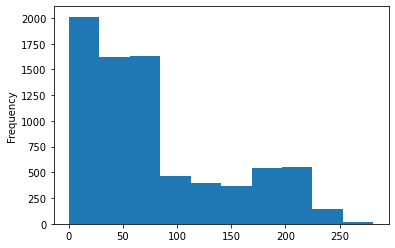

In [104]:
df_IP.plot.hist()

<AxesSubplot:ylabel='Frequency'>

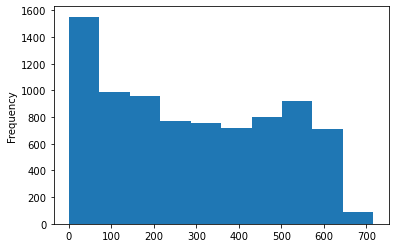

In [105]:
df_AB =  ESPN_stats_bio_FA_df.loc[ESPN_stats_bio_FA_df["TYPE"].isin(["bat"]),"AB"]
df_AB.plot.hist()

篩選

In [63]:
mask_pic = (ESPN_stats_bio_FA_df["season_num"]>=2006) & (ESPN_stats_bio_FA_df["season_num"]<=2019) & (ESPN_stats_bio_FA_df["Yrs"]>=6)
ESPN_stats_bio_FA_pic_df = ESPN_stats_bio_FA_df[mask_pic].reset_index(drop=True)
print(len(ESPN_stats_bio_FA_df),len(ESPN_stats_bio_FA_pic_df))

15998 6601


In [64]:
mask_pitch = (ESPN_stats_bio_FA_pic_df["TYPE"].isin(["pitch"])) & (ESPN_stats_bio_FA_pic_df["IP"]>=30)
mask_bat = (ESPN_stats_bio_FA_pic_df["TYPE"].isin(["bat"])) & (ESPN_stats_bio_FA_pic_df["AB"]>=60)

In [65]:
# 篩選出賽條件
print(len(ESPN_stats_bio_FA_pic_df))
ESPN_stats_bio_FA_pic_df = ESPN_stats_bio_FA_pic_df.loc[mask_pitch|mask_bat,:].reset_index(drop=True)
print(len(ESPN_stats_bio_FA_pic_df))

6601
5329


#### 區分 bat、pitch 輸出

In [164]:
# ESPN_stats_bio_FA_pic_df.columns.to_list()

In [66]:
col_output_bat = [
 'season',
 'season_num',
 'Team',
 'GP',
#  'GS',
 'WAR',
#  'ERA',
#  'IP',
#  'K/BB',
 'playerID',
 'playerID_num',
 'Yrs',
 'AB',
 'OPS',
#  'POS',
#  'DOB',
#  'Birthplace',
 'TYPE',
 'POS_c',
#  'DOB_fmt',
 'Age',
  'Age_sq',
 'YEAR',
 'ORG_TEAM_ID',
 'NEW_TEAM_ID',
 'contract_Yrs',
#  'DOLLARS',
 'STATUS',
 'DOLLARS_M',
#  'mutilTeam_count',
 'is_FA_contract_year',
 'is_FA_contract_year_before',
 'is_FA_contract_year_after',
#  'season_plus_1',
 'FIRST',
 'END'
]

formtoXlsx(ESPN_stats_bio_FA_pic_df.loc[ESPN_stats_bio_FA_pic_df["TYPE"].isin(["bat"]),col_output_bat].reset_index(drop=True), "ESPN_haveTeam_bat")
ESPN_stats_bio_FA_pic_df.loc[ESPN_stats_bio_FA_pic_df["TYPE"].isin(["bat"]),col_output_bat].reset_index(drop=True).to_stata('ESPN_haveTeam_bat.dta')


col_output_pitch = [
 'season',
 'season_num',
 'Team',
 'GP',
 'GS',
 'WAR',
 'ERA',
 'IP',
 'K/BB',
 'playerID',
  'playerID_num',
 'Yrs',
#  'AB',
#  'OPS',
#  'POS',
#  'DOB',
#  'Birthplace',
 'TYPE',
 'POS_c',
#  'DOB_fmt',
 'Age',
 'Age_sq',
 'YEAR',
 'ORG_TEAM_ID',
 'NEW_TEAM_ID',
 'contract_Yrs',
#  'DOLLARS',
 'STATUS',
 'DOLLARS_M',
#  'mutilTeam_count',
 'is_FA_contract_year',
 'is_FA_contract_year_before',
 'is_FA_contract_year_after',
#  'season_plus_1',
 'FIRST',
 'END'
]

formtoXlsx(ESPN_stats_bio_FA_pic_df.loc[ESPN_stats_bio_FA_pic_df["TYPE"].isin(["pitch"]),col_output_pitch].reset_index(drop=True), "ESPN_haveTeam_pitch")
ESPN_stats_bio_FA_pic_df.loc[ESPN_stats_bio_FA_pic_df["TYPE"].isin(["pitch"]),col_output_pitch].reset_index(drop=True).to_stata('ESPN_haveTeam_pitch.dta')

C:\Users\Daguan\miniconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


 >>> 建立今天的工作區: 0530
 ==輸出備份xlsx== ::: ESPN_haveTeam_bat_20210530_13.27.38.xlsx
 ==輸出備份xlsx== ::: ESPN_haveTeam_pitch_20210530_13.27.48.xlsx


C:\Users\Daguan\miniconda3\lib\site-packages\pandas\io\stata.py:2303: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    b'K/BB'   ->   K_BB

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  warnings.warn(ws, InvalidColumnName)


###  no team gp版

In [67]:
mask_pic = (ESPN_stats_bio_FA_no_team_gp_df["season_num"]>=2006) & (ESPN_stats_bio_FA_no_team_gp_df["season_num"]<=2019) & (ESPN_stats_bio_FA_no_team_gp_df["Yrs"]>=6)
ESPN_stats_bio_FA_no_team_gp_pic_df = ESPN_stats_bio_FA_no_team_gp_df[mask_pic].reset_index(drop=True)
print(len(ESPN_stats_bio_FA_no_team_gp_df),len(ESPN_stats_bio_FA_no_team_gp_pic_df))

14864 5711


In [68]:
mask_pitch = (ESPN_stats_bio_FA_no_team_gp_pic_df["TYPE"].isin(["pitch"])) & (ESPN_stats_bio_FA_no_team_gp_pic_df["IP"]>=30)
mask_bat = (ESPN_stats_bio_FA_no_team_gp_pic_df["TYPE"].isin(["bat"])) & (ESPN_stats_bio_FA_no_team_gp_pic_df["AB"]>=60)

In [69]:
# 篩選出賽條件
print(len(ESPN_stats_bio_FA_no_team_gp_pic_df))
ESPN_stats_bio_FA_no_team_gp_pic_df = ESPN_stats_bio_FA_no_team_gp_pic_df.loc[mask_pitch|mask_bat,:].reset_index(drop=True)
print(len(ESPN_stats_bio_FA_no_team_gp_pic_df))

5711
5028


#### 區分 bat、pitch 輸出

In [169]:
# ESPN_stats_bio_FA_no_team_gp_df.columns.to_list()

In [75]:
col_output_bat = [
 'playerID',
 'playerID_num',
 'season',
 'season_num',
 'TYPE',
 'GP',
 'WAR',
#  'GS',
#  'IP',
#  'K/BB',
 'AB',
 'OPS',
#  'ERA',
 'Yrs',
#  'Birthplace',
 'POS_c',
 'Age',
 'Age_sq',
 'YEAR',
 'ORG_TEAM_ID',
 'NEW_TEAM_ID',
 'contract_Yrs',
#  'DOLLARS',
 'STATUS',
 'DOLLARS_M',
#  'mutilTeam_count',
 'is_FA_contract_year',
 'is_FA_contract_year_before',
 'is_FA_contract_year_after',
#  'WAR_lag_1',
#  'WAR_lag_1_MA3',
 'WAR_DV',
#  'ERA_lag_1',
#  'ERA_lag_1_MA3',
#  'ERA_DV',
#  'OPS_lag_1',
#  'OPS_lag_1_MA3',
 'OPS_DV',
 'AB_DV',
#  'season_plus_1',
 'FIRST',
 'END'
]


formtoXlsx(ESPN_stats_bio_FA_no_team_gp_pic_df.loc[ESPN_stats_bio_FA_no_team_gp_pic_df["TYPE"].isin(["bat"]),col_output_bat].reset_index(drop=True), "ESPN_noTeam_bat")
ESPN_stats_bio_FA_no_team_gp_pic_df.loc[ESPN_stats_bio_FA_no_team_gp_pic_df["TYPE"].isin(["bat"]),col_output_bat].reset_index(drop=True).to_stata('ESPN_noTeam_bat.dta')

col_output_pitch = [
 'playerID',
 'playerID_num',
 'season',
 'season_num',
 'TYPE',
 'GP',
 'WAR',
 'GS',
 'IP',
 'K/BB',
#  'AB',
#  'OPS',
 'ERA',
 'Yrs',
#  'Birthplace',
 'POS_c',
 'Age',
 'Age_sq',
 'YEAR',
 'ORG_TEAM_ID',
 'NEW_TEAM_ID',
 'contract_Yrs',
#  'DOLLARS',
 'STATUS',
 'DOLLARS_M',
#  'mutilTeam_count',
 'is_FA_contract_year',
 'is_FA_contract_year_before',
 'is_FA_contract_year_after',
#  'WAR_lag_1',
#  'WAR_lag_1_MA3',
 'WAR_DV',
#  'ERA_lag_1',
#  'ERA_lag_1_MA3',
 'ERA_DV',
#  'OPS_lag_1',
#  'OPS_lag_1_MA3',
#  'OPS_DV',
 'K/BB_DV',
 'IP_DV',
#  'season_plus_1',
 'FIRST',
 'END'
]

formtoXlsx(ESPN_stats_bio_FA_no_team_gp_pic_df.loc[ESPN_stats_bio_FA_no_team_gp_pic_df["TYPE"].isin(["pitch"]),col_output_pitch].reset_index(drop=True), "ESPN_noTeam_pitch")
ESPN_stats_bio_FA_no_team_gp_pic_df.loc[ESPN_stats_bio_FA_no_team_gp_pic_df["TYPE"].isin(["pitch"]),col_output_pitch].reset_index(drop=True).to_stata('ESPN_noTeam_pitch.dta')

 ==輸出備份xlsx== ::: ESPN_noTeam_bat_20210503_20.06.00.xlsx
 ==輸出備份xlsx== ::: ESPN_noTeam_pitch_20210503_20.06.08.xlsx


C:\Users\Daguan\miniconda3\lib\site-packages\pandas\io\stata.py:2303: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    b'K/BB'   ->   K_BB
    b'K/BB_DV'   ->   K_BB_DV

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  warnings.warn(ws, InvalidColumnName)


In [171]:
# have_team_bat = read_data_dir_fPathExt(r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\6.ESPN_free_agent\有team_bat_20210417_22.43.03.csv")
# have_team_pitch = read_data_dir_fPathExt(r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\6.ESPN_free_agent\有team_pitch_20210417_22.43.03.csv")

# no_team_bat = read_data_dir_fPathExt(r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\6.ESPN_free_agent\no_team_gp_bat_20210417_22.43.08.csv")
# no_team_pitch = read_data_dir_fPathExt(r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\6.ESPN_free_agent\no_team_gp_pitch_20210417_22.43.08.csv")